## Process and Visualize IWG data from Arctic Heat

Arctic Heat IWG files are obtained during aircraft flights.  Using python and a few standard data analysis and visualization packages, we can take a few quick looks into the data.

**Note** GMT-Python is in heavy development and may not be available unless you are on a mac or linux machine.  Alternatives are Cartopy or outputing your data into your favorite GIS software.

For more information on the analysis, contact: Shaun.Bell@noaa.gov

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cmocean

import pandas as pd
import numpy as np

import os

### Data Ingestion and data summary/statistics

A few lines to list and read the .iwg files into a dictionary of pandas dataframes.

The original .iwg files have headerlines everyso often through the file.  I usually clean these up by removing all of the lines and adding one iteration of headers at the top of the file and then call these files ".clean"

In [30]:
source_dir = '/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/'

source_file = [os.path.join(dp, f) for dp, dn,
   fn in os.walk(os.path.expanduser(source_dir)) for f in fn if '.dat' in f]


In [31]:
dfs = {}
for i,filename in enumerate(source_file):
    try:
        dfs.update({filename:pd.read_csv(filename,delimiter=',',
                                         parse_dates=['TIME'],index_col='TIME')})
        print(filename)
    except ValueError:
        print("{} failed to load".format(filename))
        continue

/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/20190720L1_FDlog.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/ANALOG/20190720_170527_analog_raw.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/SHADIN/20190720_170527Shadin_RAW.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190719_210910_AIMMS_RAW.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190719_210910_IWG.thinned.dat
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190720_170527_IWG.dat
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190719_210910_IWG.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190720_170527_AIMMS_RAW.dat failed to load
/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190717L2/20190717L2b_FDlog.dat failed to 

In [32]:
for file in dfs.keys():
    print("Summary for file:{}".format(file))
    print(dfs[file].describe())

Summary for file:/Users/bell/ecoraid/2019/Additional_FieldData/ArcticHeat/20190720L1/AIMMS/20190719_210910_IWG.thinned.dat
                LAT           LON        ALTGPS  GPS_GEOIDHT       ALTPAFT  \
count  12405.000000  12405.000000  12405.000000          0.0  12405.000000   
mean      73.518010   -157.517416   1573.645788          NaN   5482.084643   
std        1.119419      1.131934   1351.750604          NaN   4559.650411   
min       71.273430   -160.472107     13.000000          NaN     60.000000   
25%       72.766106   -158.046814    154.000000          NaN    710.000000   
50%       73.654770   -156.918915   1620.000000          NaN   5740.000000   
75%       74.491196   -156.822296   2983.000000          NaN  10260.000000   
max       75.101250   -156.317184   3062.000000          NaN  10380.000000   

            ALTRAFT            GS           TAS           IAS          MACH  \
count  12405.000000  12405.000000  12405.000000  12405.000000  12405.000000   
mean     249.076

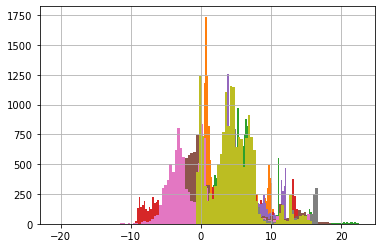

In [33]:
for file in dfs.keys():
    dfs[file]['SST'].hist(bins=100)

### Geolocated Plots of SST/Flight Altitude

After having imported and glanced at the data and statistics, lets plot the SST as a function of flight path

In [67]:
import pygmt as gmt

In [84]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 70, 76], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

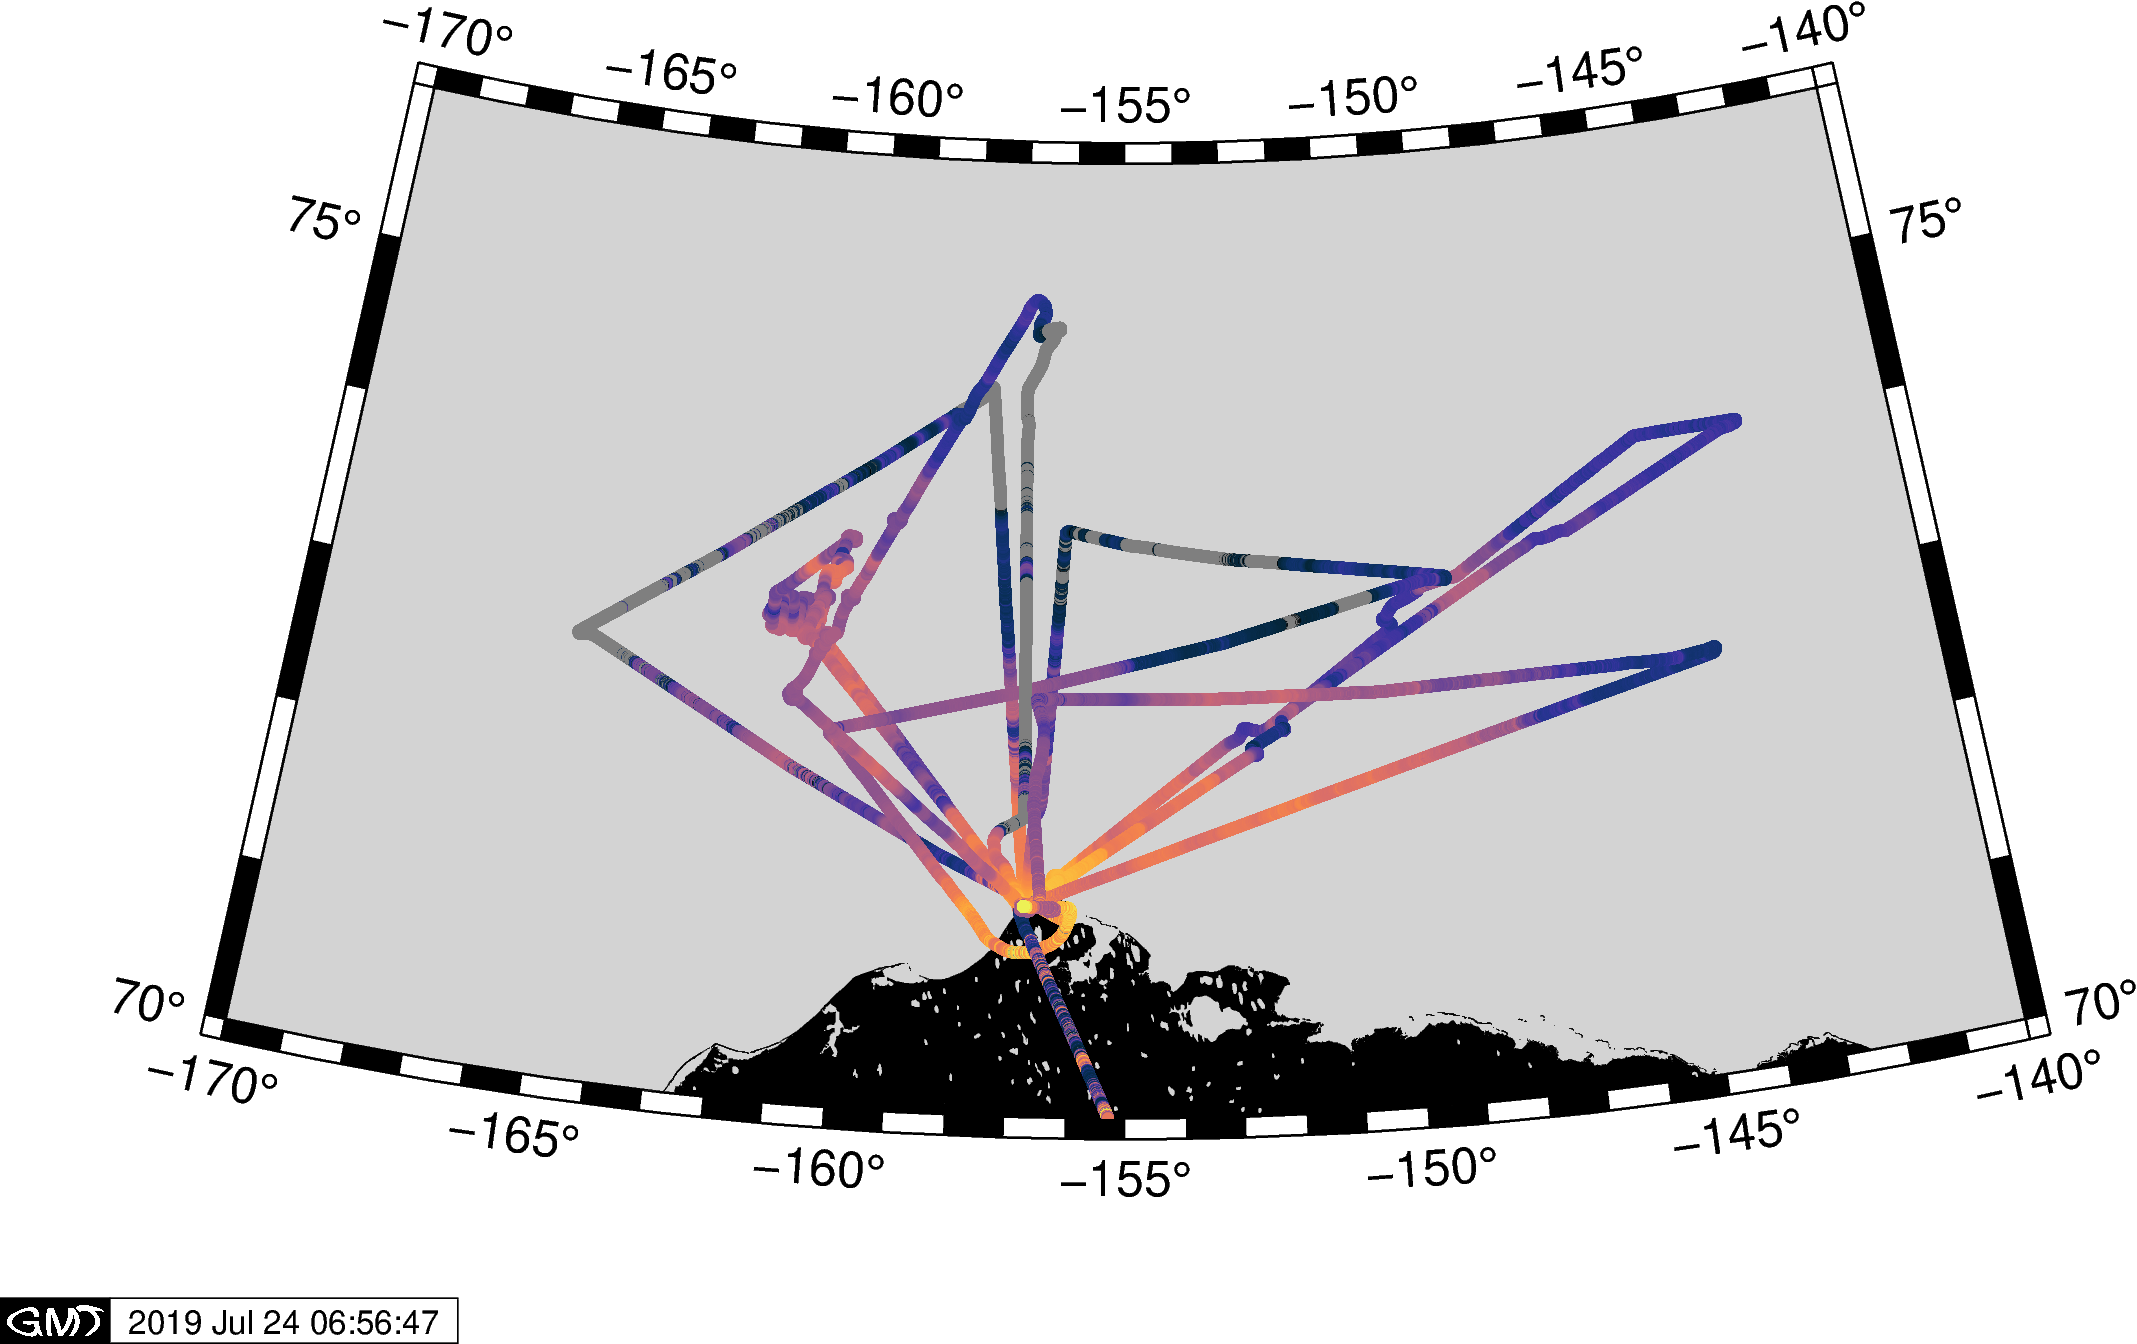

In [93]:
#choose temp boundaries
upper_limit = 12
lower_limit = -2

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['SST'].loc[(dfs[file]['SST'] > upper_limit ) | (dfs[file]['SST'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['SST'].apply(lambda x: (x - (lower_limit)) / (upper_limit - (lower_limit)))
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=256*dfnorm, cmap='thermal', style='c0.1c')


fig.show()

In [92]:
fig = gmt.Figure()

fig.coast(region=[-170, -140, 70, 76], projection='B-155/60/55/60/6i', land='black', water='lightgrey',
          frame=True,U=True) 

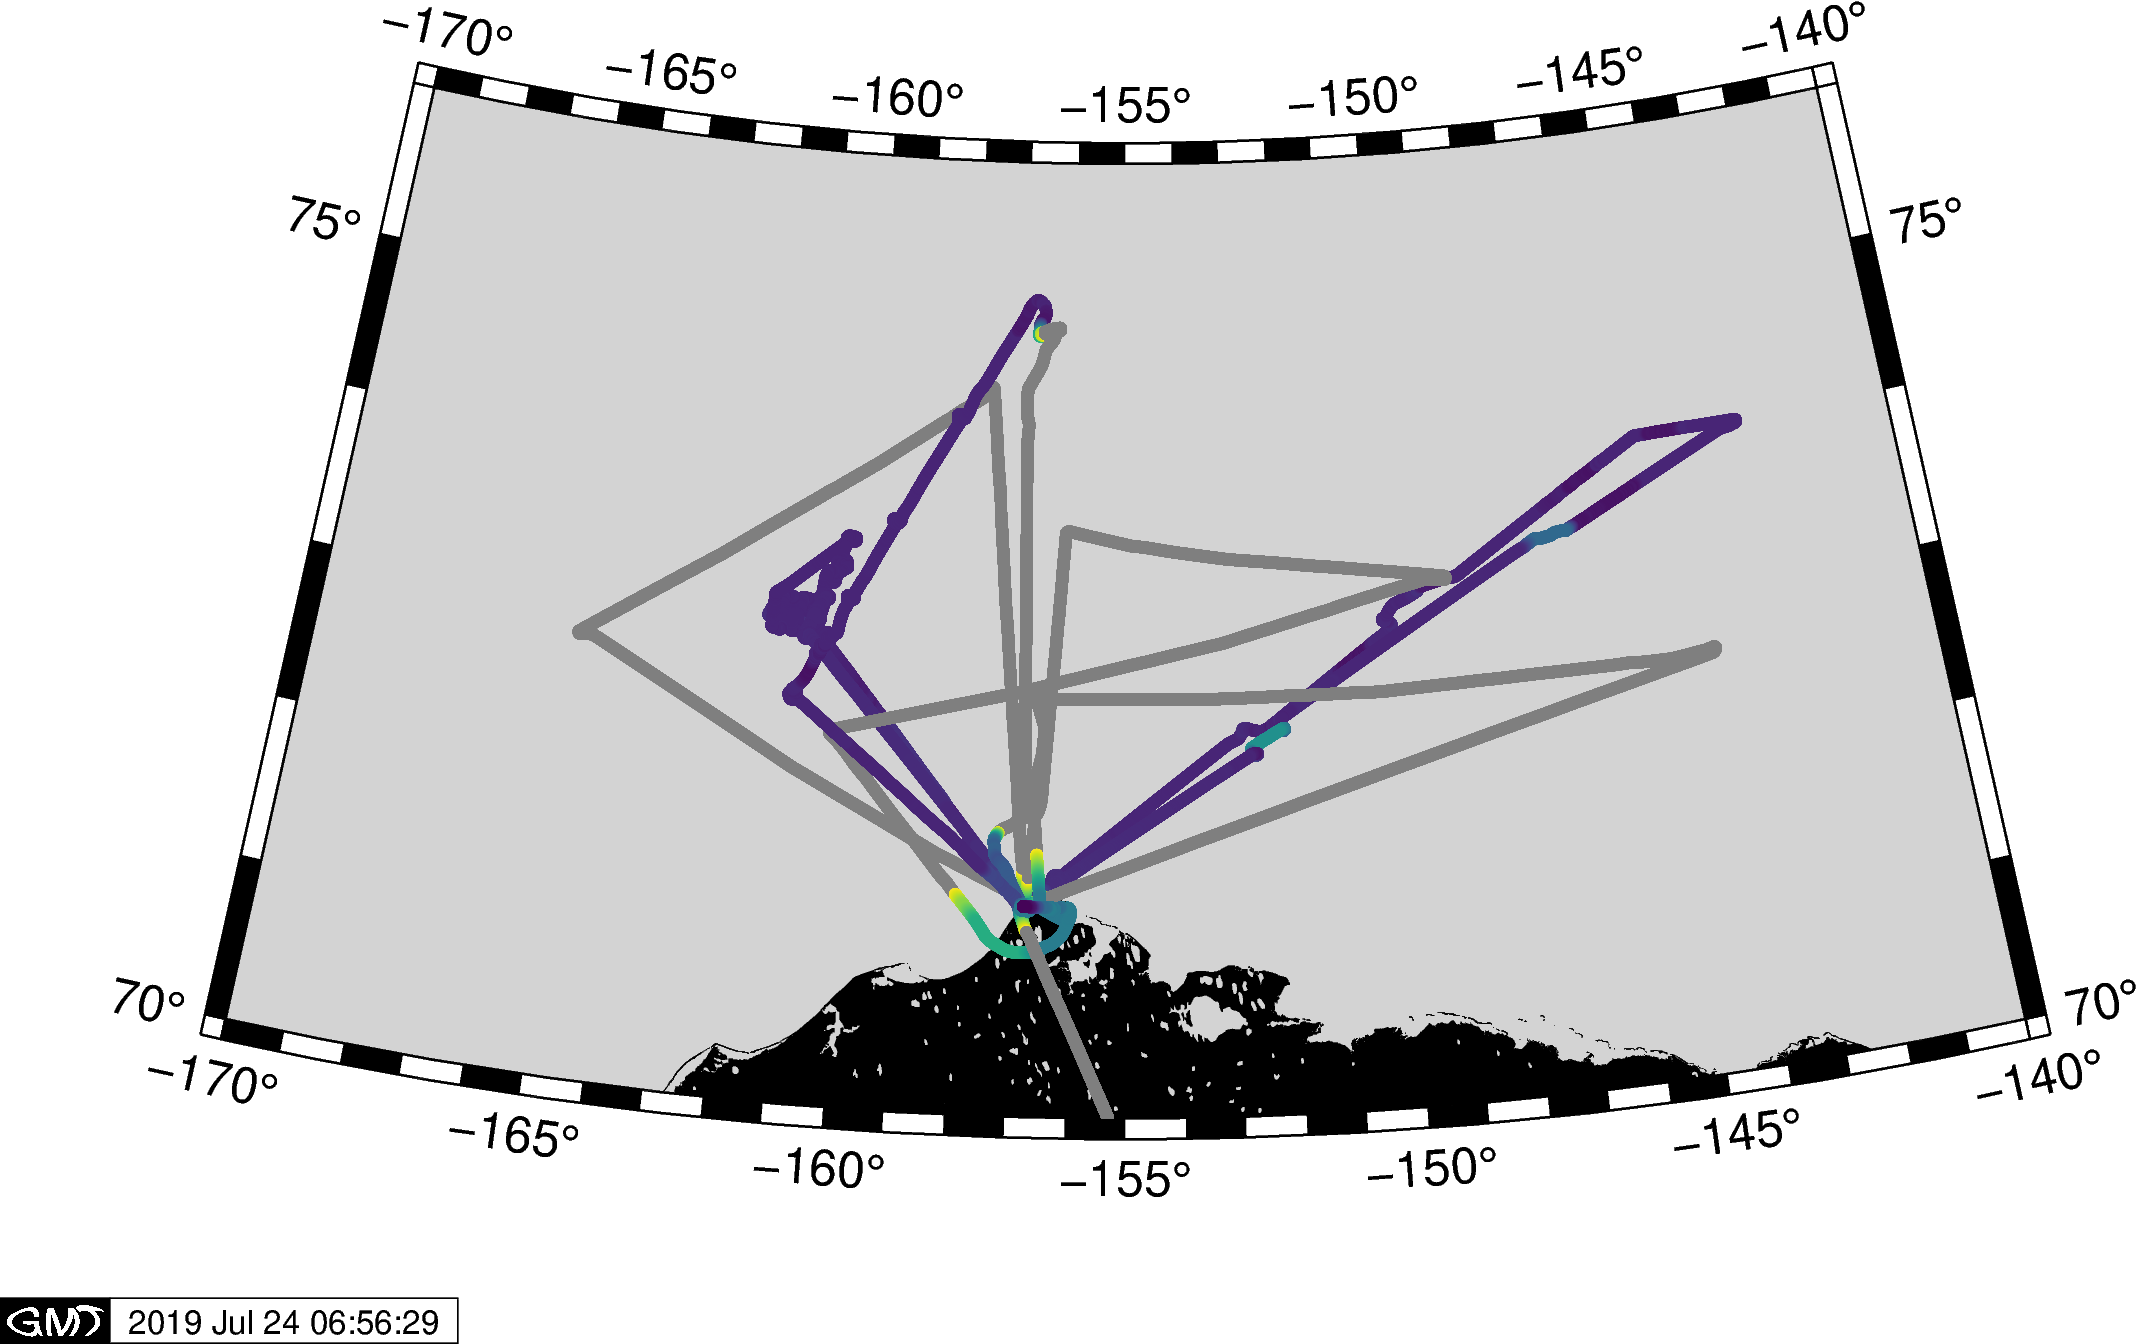

In [90]:
#choose altitude boundaries
upper_alt = 1500 #ft
#lower is 0ft

for file in dfs.keys():
    dfmiss = dfs[file].copy()
    dfmiss['ALTGPS'].loc[(dfs[file]['ALTGPS'] > upper_alt ) | (dfs[file]['ALTGPS'] <lower_limit)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss['ALTGPS'].apply(lambda x: (x - (0)) / (upper_alt - (0)))
    #if a cmocean colormap is used like thermal - then you need to add it to your gmt-python env
    fig.plot(x=dfs[file].LON.values, y=dfs[file].LAT.values, color=dfnorm, cmap='viridis', style='c0.1c')

fig.show()

areas greyed out above are above 500ft.  darker blue regions are lower while lighter green regions are higher

### Plotting Time vs Altitude color coded by SST

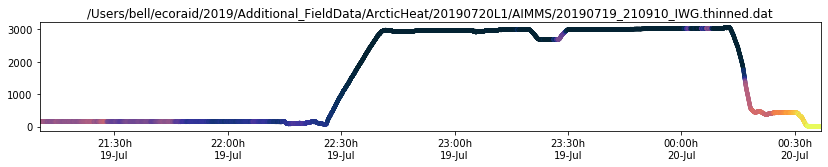

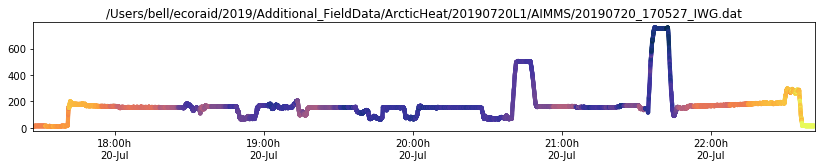

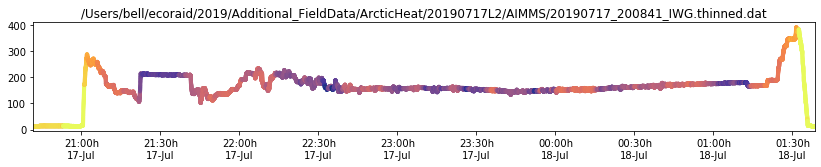

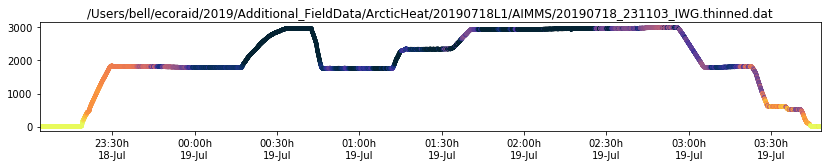

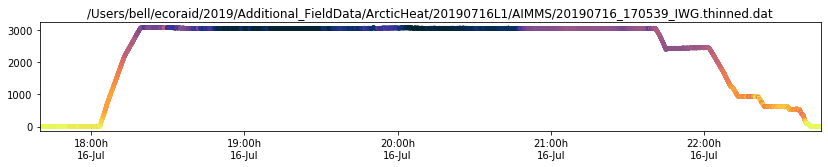

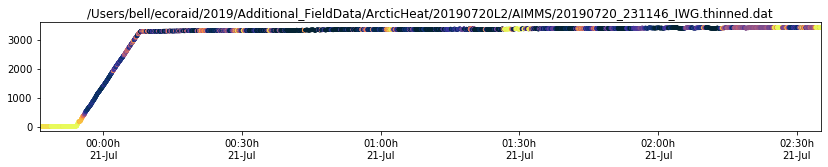

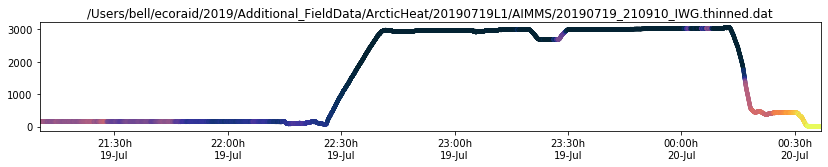

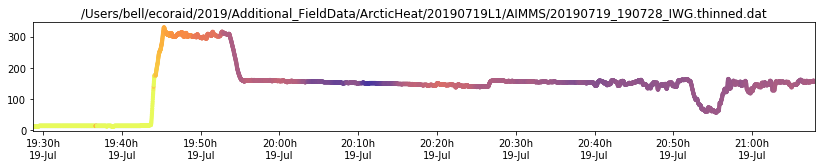

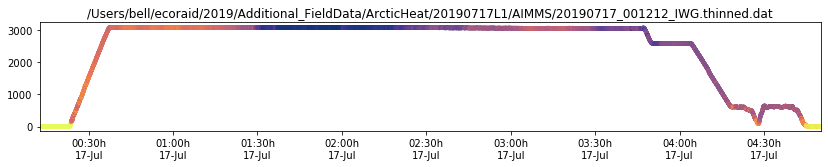

In [95]:
for file in dfs.keys():
    fig = plt.figure(figsize=(14, 2))
    ax1 = fig.add_subplot(111)
    plt.scatter(dfs[file].index,dfs[file]['ALTGPS'],
                s=10,c=dfs[file]['SST'],cmap=cmocean.cm.thermal,
                vmin=lower_limit,vmax=upper_limit)
    ax1.set_xlim(dfs[file].index.min(),dfs[file].index.max())
    xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
    ax1.xaxis.set_major_formatter(xfmt)
    plt.title(file)

### Color Bar Creation

Creating a consistent color bar for the thermal plots.  Maptlotlib can do this inherently but the GMT-Python package

In [62]:
def colorbar(cmap=cmocean.cm.thermal,label='',lower_limit=0,upper_limit=10):

    '''
    ====================
    Customized colorbars
    ====================

    This example shows how to build colorbars without an attached mappable.
    '''

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import cmocean

    # Make a figure and axes with dimensions as desired.
    fig = plt.figure(figsize=(8, 3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    # Set the colormap and norm to correspond to the data for which
    # the colorbar will be used.
    if type(cmap) is str:
        cmap = plt.get_cmap(cmap,256)
    else:
        cmap = cmap
    norm = mpl.colors.Normalize(vmin=lower_limit, vmax=upper_limit)

    # ColorbarBase derives from ScalarMappable and puts a colorbar
    # in a specified axes, so it has everything needed for a
    # standalone colorbar.  There are many more kwargs, but the
    # following gives a basic continuous colorbar with ticks
    # and labels.
    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label(label)

    # The second example illustrates the use of a ListedColormap, a
    # BoundaryNorm, and extended ends to show the "over" and "under"
    # value colors.
    cmap = mpl.colors.ListedColormap(['r', 'g', 'b', 'c'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    plt.show()

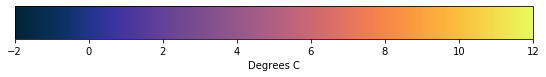

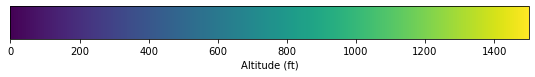

In [94]:
colorbar(cmocean.cm.thermal,'Degrees C',lower_limit=-2,upper_limit=12)
colorbar('viridis','Altitude (ft)',lower_limit=0,upper_limit=1500)